In [1]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [2]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Load Data and Preprocessing

In [2]:
# Import dataset
G = nx.read_graphml( "data/cora/cora.graphml" )

print(G) # should print a graph with 2708 nodes and 5429 edges (directed) 

# in this case, we have created a undirected graph, so the numbers of edges are diffent from the original paper

Graph with 2708 nodes and 5278 edges


In [3]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [4]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) ) # 1-1432: weights, 1433: subject

[
    "1033",
    {
        "label": "paper",
        "w_0": 0,
        "w_1": 0,
        "w_2": 0,
        "w_3": 0,
        "w_4": 0,
        "w_5": 0,
        "w_6": 0,
        "w_7": 0,
        "w_8": 0,
        "w_9": 1,
        "w_10": 0,
        "w_11": 0,
        "w_12": 0,
        "w_13": 0,
        "w_14": 0,
        "w_15": 0,
        "w_16": 0,
        "w_17": 0,
        "w_18": 0,
        "w_19": 0,
        "w_20": 0,
        "w_21": 0,
        "w_22": 0,
        "w_23": 0,
        "w_24": 0,
        "w_25": 0,
        "w_26": 0,
        "w_27": 0,
        "w_28": 0,
        "w_29": 0,
        "w_30": 0,
        "w_31": 0,
        "w_32": 0,
        "w_33": 0,
        "w_34": 0,
        "w_35": 0,
        "w_36": 0,
        "w_37": 0,
        "w_38": 0,
        "w_39": 0,
        "w_40": 0,
        "w_41": 0,
        "w_42": 0,
        "w_43": 0,
        "w_44": 0,
        "w_45": 0,
        "w_46": 0,
        "w_47": 0,
        "w_48": 0,
        "w_49": 0,
        "w_50"

In [7]:
# NOT NEEDED FOR HOW I'M USING THE DATASET

# rename '1433' to 'subject'
for node in G.nodes():
    G.nodes[node]['subject'] = G.nodes[node].pop("1433")

KeyError: '1433'

In [5]:
for node in G.nodes():
    print( G.nodes[node]['subject'] )
    break

Genetic_Algorithms


In [6]:
# remove 'feature' from node attributes
for node in G.nodes():
    G.nodes[node].pop("feature")

KeyError: 'feature'

In [7]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'subject' and key != 'label' ]
    G.nodes[node]['feature'] = enc

In [9]:
for node in G.nodes( data=True ):
    print( node )
    break

('1033', {'label': 'paper', 'w_0': 0, 'w_1': 0, 'w_2': 0, 'w_3': 0, 'w_4': 0, 'w_5': 0, 'w_6': 0, 'w_7': 0, 'w_8': 0, 'w_9': 1, 'w_10': 0, 'w_11': 0, 'w_12': 0, 'w_13': 0, 'w_14': 0, 'w_15': 0, 'w_16': 0, 'w_17': 0, 'w_18': 0, 'w_19': 0, 'w_20': 0, 'w_21': 0, 'w_22': 0, 'w_23': 0, 'w_24': 0, 'w_25': 0, 'w_26': 0, 'w_27': 0, 'w_28': 0, 'w_29': 0, 'w_30': 0, 'w_31': 0, 'w_32': 0, 'w_33': 0, 'w_34': 0, 'w_35': 0, 'w_36': 0, 'w_37': 0, 'w_38': 0, 'w_39': 0, 'w_40': 0, 'w_41': 0, 'w_42': 0, 'w_43': 0, 'w_44': 0, 'w_45': 0, 'w_46': 0, 'w_47': 0, 'w_48': 0, 'w_49': 0, 'w_50': 0, 'w_51': 0, 'w_52': 0, 'w_53': 0, 'w_54': 0, 'w_55': 0, 'w_56': 0, 'w_57': 0, 'w_58': 0, 'w_59': 0, 'w_60': 0, 'w_61': 0, 'w_62': 0, 'w_63': 0, 'w_64': 0, 'w_65': 0, 'w_66': 0, 'w_67': 0, 'w_68': 0, 'w_69': 0, 'w_70': 0, 'w_71': 0, 'w_72': 0, 'w_73': 0, 'w_74': 0, 'w_75': 0, 'w_76': 0, 'w_77': 0, 'w_78': 0, 'w_79': 0, 'w_80': 0, 'w_81': 0, 'w_82': 0, 'w_83': 0, 'w_84': 0, 'w_85': 0, 'w_86': 0, 'w_87': 0, 'w_88': 0, 'w_

In [8]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'subject' and key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [9]:
# print node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('1033', {'label': 'paper', 'subject': 'Genetic_Algorithms', 'feature': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "1033",
    {
        "label": "paper",
        "subject": "Genetic_Algorithms",
        "feature": [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
       

In [10]:
print( json.dumps( list( G.edges(data=True) )[0:10], indent = 4 ) )

[
    [
        "1033",
        "35",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "1034",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "1107062",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "41714",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "45605",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "103482",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "103515",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "1050679",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "1103960",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "1103985",
        {
            "label": "cites"
        }
    ]
]


## Create StellarGraph

In [11]:
SG = StellarGraph.from_networkx(
    graph=G, node_type_default="subject", node_features="feature"
)

print( SG.info() )

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]
        Weights: all 1 (default)
        Features: none


In [16]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

1033       Genetic_Algorithms
35         Genetic_Algorithms
103482        Neural_Networks
103515     Genetic_Algorithms
1050679    Genetic_Algorithms
dtype: object


In [18]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

print( train_subjects )

1153097           Neural_Networks
164                        Theory
132806         Genetic_Algorithms
1114992           Neural_Networks
1131611                    Theory
                    ...          
1113831        Genetic_Algorithms
28412      Reinforcement_Learning
89416       Probabilistic_Methods
14428       Probabilistic_Methods
267824            Neural_Networks
Length: 270, dtype: object


In [19]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({'Neural_Networks': 81,
         'Theory': 35,
         'Genetic_Algorithms': 42,
         'Reinforcement_Learning': 22,
         'Probabilistic_Methods': 42,
         'Rule_Learning': 18,
         'Case_Based': 30})

In [20]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)

In [21]:
print( train_targets ) # for each node, the subject is encoded as a number

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


## Define benchmarking metrics

In [36]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score


def benchmarking_result( targets, predictions ) :
    # Accuracy
    train_acc = np.mean( targets == predictions )

    # Confusion matrix
    # cm = confusion_matrix( targets, predictions )

    # Precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support( targets, predictions, average='micro' )

    # AUC-ROC
    # auc = roc_auc_score( targets, predictions )

    return train_acc, precision, recall, f1


## GraphSAGE model

In [23]:
batch_size = 50
num_samples = [10, 10, 5]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [24]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [25]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32, 16], generator=generator, bias=True, dropout=0.5
)

In [26]:
print( train_targets.shape )

(270, 7)


In [27]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [28]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [29]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [30]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
6/6 - 15s - loss: 1.8678 - acc: 0.3037 - val_loss: 1.7221 - val_acc: 0.3396 - 15s/epoch - 2s/step
Epoch 2/20
6/6 - 14s - loss: 1.7150 - acc: 0.3852 - val_loss: 1.6048 - val_acc: 0.4861 - 14s/epoch - 2s/step
Epoch 3/20
6/6 - 14s - loss: 1.5911 - acc: 0.5667 - val_loss: 1.5059 - val_acc: 0.6448 - 14s/epoch - 2s/step
Epoch 4/20
6/6 - 11s - loss: 1.4670 - acc: 0.6815 - val_loss: 1.3895 - val_acc: 0.6821 - 11s/epoch - 2s/step
Epoch 5/20
6/6 - 11s - loss: 1.3530 - acc: 0.7222 - val_loss: 1.2977 - val_acc: 0.7043 - 11s/epoch - 2s/step
Epoch 6/20
6/6 - 13s - loss: 1.2512 - acc: 0.7778 - val_loss: 1.2256 - val_acc: 0.7034 - 13s/epoch - 2s/step
Epoch 7/20
6/6 - 13s - loss: 1.1679 - acc: 0.7741 - val_loss: 1.1635 - val_acc: 0.7043 - 13s/epoch - 2s/step
Epoch 8/20
6/6 - 11s - loss: 1.0916 - acc: 0.7963 - val_loss: 1.1255 - val_acc: 0.6936 - 11s/epoch - 2s/step
Epoch 9/20
6/6 - 12s - loss: 1.0051 - acc: 0.8148 - val_loss: 1.0717 - val_acc: 0.7022 - 12s/epoch - 2s/step
Epoch 10/20
6/6 - 1

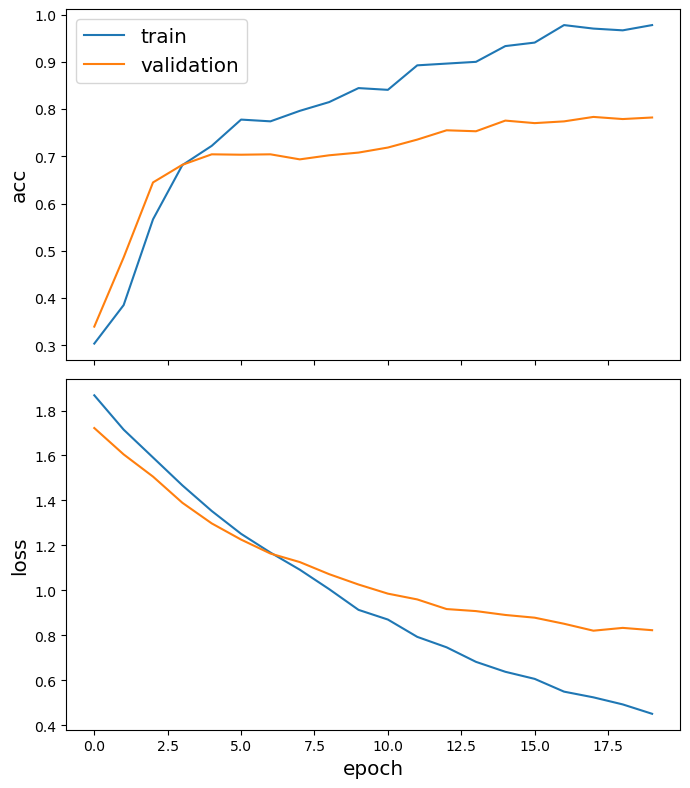

In [31]:
sg.utils.plot_history(history)

In [32]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 10s 199ms/step - loss: 0.8205 - acc: 0.7875

Test Set Metrics:
	loss: 0.8205
	acc: 0.7875


### Benchmark model

In [33]:
# print benchmarking results
targets = np.argmax( test_targets, axis=1 )
predictions = np.argmax( model.predict(test_gen), axis=1 )

49/49 [==============================] - 11s 226ms/step


In [37]:
train_acc, precision, recall, f1 = benchmarking_result( targets, predictions )

print( "Accuracy: ", train_acc )
print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )

# this result is wrong

Accuracy:  0.7858900738310091
Precision:  0.7858900738310091
Recall:  0.7858900738310091
F1:  0.785890073831009


In [38]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

55/55 [==============================] - 14s 251ms/step


In [39]:
node_predictions = le.inverse_transform(all_predictions)

In [40]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
1033,Genetic_Algorithms,Genetic_Algorithms
35,Genetic_Algorithms,Genetic_Algorithms
103482,Theory,Neural_Networks
103515,Genetic_Algorithms,Genetic_Algorithms
1050679,Genetic_Algorithms,Genetic_Algorithms
1103960,Genetic_Algorithms,Genetic_Algorithms
1103985,Genetic_Algorithms,Genetic_Algorithms
1109199,Genetic_Algorithms,Genetic_Algorithms
1112911,Genetic_Algorithms,Genetic_Algorithms
1113438,Genetic_Algorithms,Genetic_Algorithms


In [41]:
# calculate accuracy
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

True     2182
False     526
Name: Correct, dtype: int64

In [42]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

0.8057607090103397


## GCN model

In [43]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects, random_state=42
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [44]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [45]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [46]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [47]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [48]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [49]:
x_inp, x_out = gcn.in_out_tensors()

In [50]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [52]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [53]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [55]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.9356 - acc: 0.2786 - val_loss: 1.9171 - val_acc: 0.3380 - 882ms/epoch - 882ms/step
Epoch 2/200
1/1 - 0s - loss: 1.9053 - acc: 0.3000 - val_loss: 1.8860 - val_acc: 0.3340 - 80ms/epoch - 80ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8677 - acc: 0.3000 - val_loss: 1.8506 - val_acc: 0.3120 - 91ms/epoch - 91ms/step
Epoch 4/200
1/1 - 0s - loss: 1.8327 - acc: 0.3357 - val_loss: 1.8155 - val_acc: 0.3080 - 87ms/epoch - 87ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7976 - acc: 0.3357 - val_loss: 1.7814 - val_acc: 0.3020 - 81ms/epoch - 81ms/step
Epoch 6/200
1/1 - 0s - loss: 1.7521 - acc: 0.3286 - val_loss: 1.7478 - val_acc: 0.3020 - 76ms/epoch - 76ms/step
Epoch 7/200
1/1 - 0s - loss: 1.6884 - acc: 0.3071 - val_loss: 1.7136 - val_acc: 0.3020 - 79ms/epoch - 79ms/step
Epoch 8/200
1/1 - 0s - loss: 1.6519 - acc: 0.3286 - val_loss: 1.6788 - val_acc: 0.3040 - 76ms/epoch - 76ms/step
Epoch 9/200
1/1 - 0s - loss: 1.5979 - acc: 0.3143 - val_loss: 1.6430 - val_acc: 0.3040 - 78ms/epoch - 

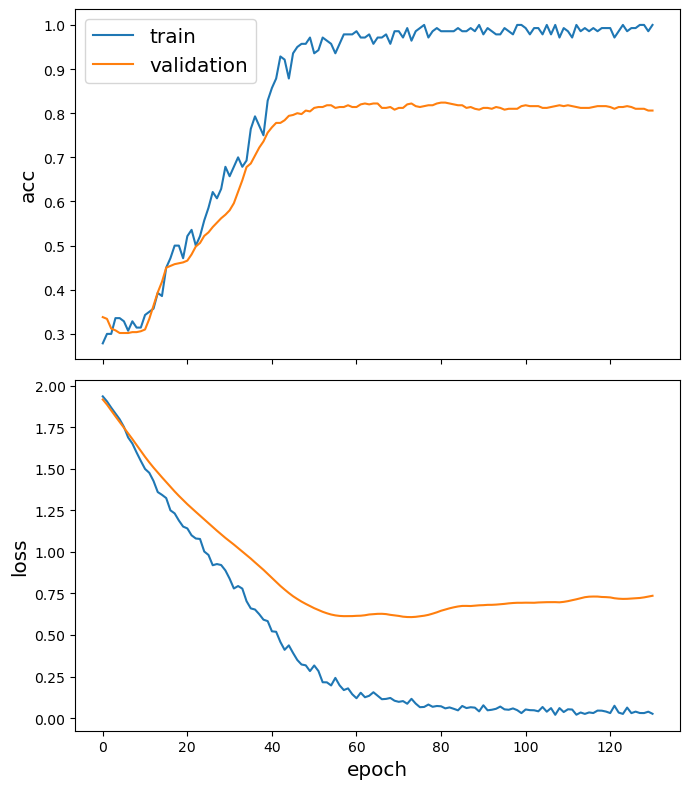

In [56]:
sg.utils.plot_history(history)

In [57]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [58]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 37ms/step - loss: 0.7748 - acc: 0.7993

Test Set Metrics:
	loss: 0.7748
	acc: 0.7993
